<a href="https://colab.research.google.com/github/iwa103/folium/blob/main/folium%EF%BC%BFInSAR_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Interferometric SAR analysis results are made into a web map using folium

干渉SAR解析結果をfoliumにてWEBマップ化

Convert Geotiff to PNG and display

GeotiffをPNGに変換して表示

1. Install the library

１．ライブラリインストール

In [ ]:
##ライブラリインストール


# GDALのインストール
!sudo apt-get update
!sudo apt-get install -y gdal-bin libgdal-dev

# 必要なPythonパッケージをインストール
!pip install rasterio


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,619 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,646 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packa

2. Create a web map with folium

2.foliumでWEBマップ作成


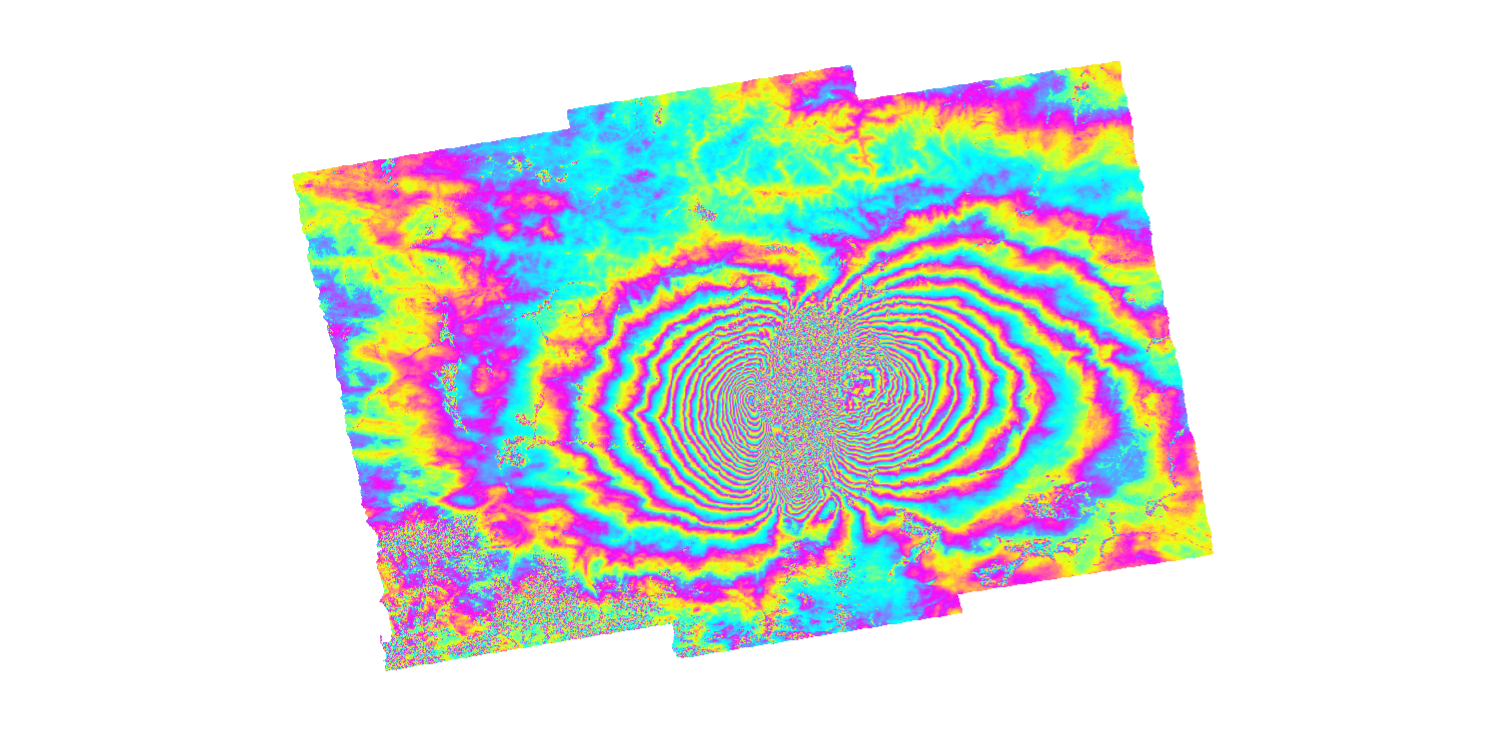
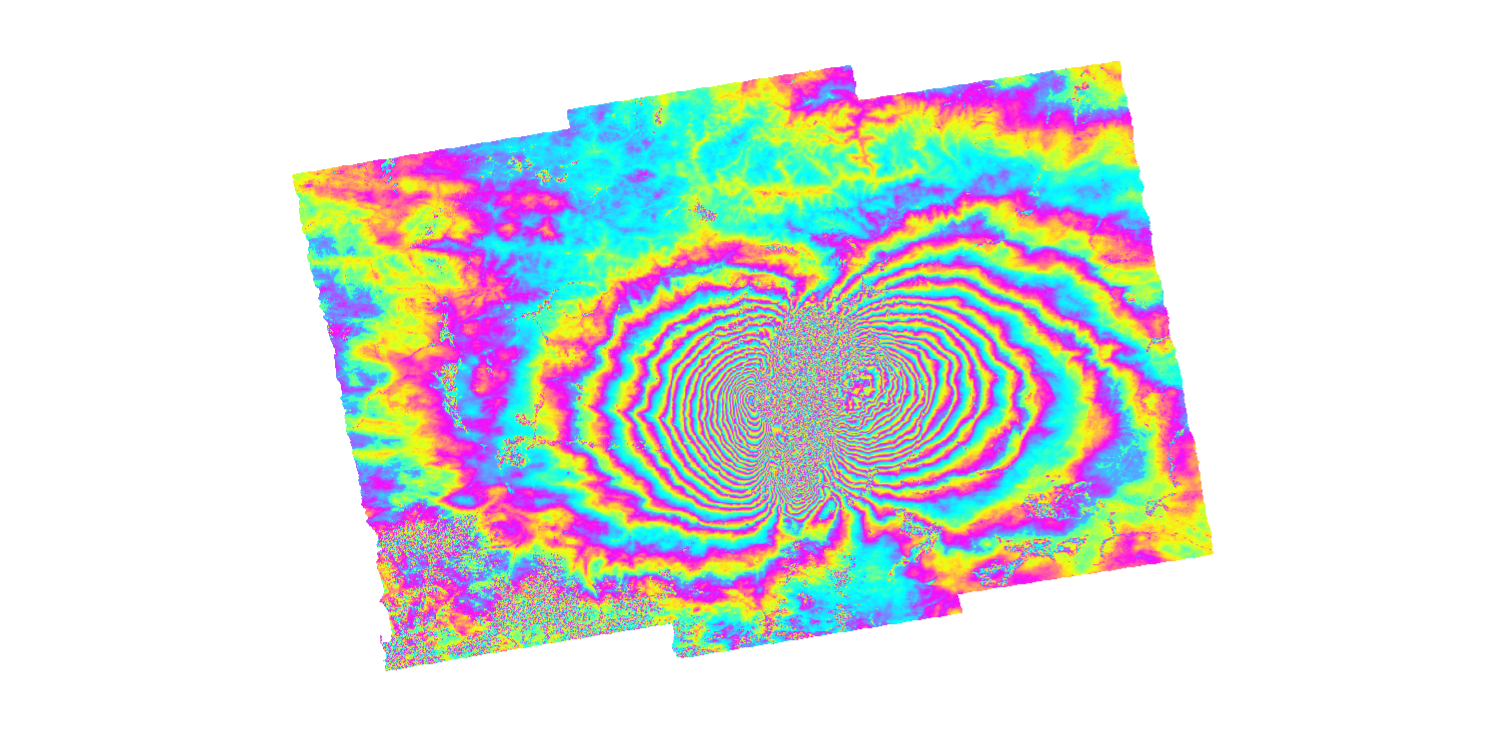

In [ ]:
import folium
import rasterio
import numpy as np
from rasterio.warp import transform_bounds
from PIL import Image

# GeoTIFF ファイルのパス
tiff_path = "/content/チベット.tif" #　表示したいファイルのパス
png_path = "/content/exp_wrap.png"  # 変換後の PNG 保存先

# GeoTIFF の境界を取得（WGS84 に変換）
with rasterio.open(tiff_path) as src:
    original_bounds = src.bounds  # 元の投影座標系の範囲
    original_crs = src.crs  # 元の座標系

    # WGS84 (EPSG:4326) に変換
    transformed_bounds = transform_bounds(original_crs, 'EPSG:4326', *original_bounds)

    # 画像データを取得（RGB の 3 バンド）
    image_data = src.read([1, 2, 3]).astype(np.float32)  # R, G, B バンドを取得（float変換）

    # 各バンドを 0-255 に正規化（全バンドの最小・最大を考慮）
    min_val = np.min(image_data)
    max_val = np.max(image_data)

    if max_val > min_val:  # 0除算防止
        image_data = (255 * (image_data - min_val) / (max_val - min_val)).astype(np.uint8)
    else:
        image_data = np.zeros_like(image_data, dtype=np.uint8)  # すべて同じ値なら真っ黒になるのを防ぐ

    # TIFF のバンド順（C, H, W）→（H, W, C）に変換
    image_data = np.moveaxis(image_data, 0, -1)

    # 白の部分を検出して透明にする
    alpha_channel = np.full((image_data.shape[0], image_data.shape[1]), 255, dtype=np.uint8)  # 初期値は不透明
    white_mask = (image_data.sum(axis=-1) == 255 * 3)  # R, G, B がすべて255のピクセルを白と判定
    alpha_channel[white_mask] = 0  # 白の部分を透明に

    # RGBA（透過情報を含む）で画像を作成
    image_rgba = np.dstack([image_data, alpha_channel])
    image = Image.fromarray(image_rgba, mode="RGBA")
    image.save(png_path)

# Folium 用に WGS84 の境界を設定
bounds = [[transformed_bounds[1], transformed_bounds[0]],  # 南西 (lat, lon)
          [transformed_bounds[3], transformed_bounds[2]]]  # 北東 (lat, lon)

# マップを初期化（画像の中心を自動設定）
m = folium.Map(location=[(bounds[0][0] + bounds[1][0]) / 2,  # 中心の緯度
                         (bounds[0][1] + bounds[1][1]) / 2], # 中心の経度
               zoom_start=8)


# 画像をオーバーレイとして追加（透明度1）
folium.raster_layers.ImageOverlay(
    name='非透明',
    image=png_path,  # 変換した PNG 画像
    bounds=bounds,  # 取得した座標範囲
    opacity=1,  # 完全に不透明
    interactive=True,
    cross_origin=False,
    zindex=1,
    show=True  # ← 初期表示する（デフォルト）
).add_to(m)

# 画像をオーバーレイとして追加（透明度0.3）
folium.raster_layers.ImageOverlay(
    name='透過',
    image=png_path,  # 変換した PNG 画像
    bounds=bounds,  # 取得した座標範囲
    opacity=0.3,  # 半透明
    interactive=True,
    cross_origin=False,
    zindex=2,
    show=False  # ← 初期非表示にする
).add_to(m)

# レイヤーコントロールを追加
folium.LayerControl().add_to(m)

# マップを HTML ファイルとして保存
m.save('map_with_geotiff.html')

m


3. Seismic intensity contour lines (display of JSON file)

3.震度の等高線（JSONファイルの表示）

Note:You need to upload the seismic intensity contour file in advance under the "content" folder.

注意：事前に”content”フォルダの下に震度の等高線ファイルをアップロード必要

In [ ]:
import folium
import os
import json
from folium.features import DivIcon

# マップを初期化（地図表示のセンター設定）
m = folium.Map(location=[31.806, 131.565], zoom_start=10)
#m = folium.Map(location=[31.0, 88.0], zoom_start=6)


# Google Mapsの航空写真タイル
google_satellite = 'https://{s}.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'
folium.TileLayer(
    tiles=google_satellite,
    attr='Google',
    name='Google Satellite',
    subdomains=['mt0', 'mt1', 'mt2', 'mt3'],
    overlay=False
).add_to(m)

# Google Mapsの通常の地図タイル
google_maps = 'https://{s}.google.com/vt/lyrs=m&x={x}&y={y}&z={z}'
folium.TileLayer(
    tiles=google_maps,
    attr='Google',
    name='Google Maps',
    subdomains=['mt0', 'mt1', 'mt2', 'mt3'],
    overlay=False
).add_to(m)

# スタイル関数を定義
def style_function(feature):
    return {
        'fillColor': feature['properties'].get('color', '#ffffff'),
        'color': feature['properties'].get('color', '#000000'),
        'weight': feature['properties'].get('weight', 0),
        'opacity': 1,
        'fillOpacity': 0.5
    }

# JSONデータの読み込みとGeoJsonレイヤーの追加
directory = '/content'
for filename in os.listdir(directory):
    if filename.endswith('.json'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='utf-8-sig') as f:
            geo_json_data = json.load(f)

        geo_json_layer = folium.GeoJson(
            geo_json_data,
            style_function=style_function,
            name=os.path.splitext(filename)[0]
        ).add_to(m)

        # ラインの中央の座標を計算してラベルを追加
        for feature in geo_json_data['features']:
            geom_type = feature['geometry']['type']
            if geom_type == 'MultiLineString':
                points = feature['geometry']['coordinates'][0]  # 最初のラインを使用
                mid_point = points[len(points)//2]
                location = [mid_point[1], mid_point[0]]
                label = str(feature['properties']['value'])
                folium.Marker(
                    location,
                    icon=DivIcon(
                        icon_size=(150,36),
                        icon_anchor=(7,20),
                        html=f'<div style="font-size: 12pt; color : black">{label}</div>',
                    )
                ).add_to(geo_json_layer)

# レイヤーコントロールを追加
folium.LayerControl().add_to(m)

# マップをHTMLファイルとして保存
m.save('eq_result.html')